#<font color= red>All Necessary Imports</font>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import joblib
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from prophet import Prophet

In [3]:
# Install AWS CLI in Colab
!pip install awscli

# Configure AWS credentials (replace placeholders with your own AWS credentials)
!aws configure



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 14.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/pyt

In [3]:
!pip install boto3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.2 MB/s eta 0:00:00


In [ ]:
import boto3
import pandas as pd

# AWS credentials
ACCESS_KEY = 'your_access_key'
SECRET_KEY = 'your_secret_key'
REGION_NAME = 'your_region_name'  # Replace with your AWS region, e.g., 'us-west-1'

# S3 bucket and file details
BUCKET_NAME = 'your_bucket_name'
FILE_NAME = 'your_file_name.csv'
LOCAL_FILE_PATH = '/content/' + FILE_NAME  # File will be downloaded to this local path in Colab

# Create an S3 client
s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY, region_name=REGION_NAME)

# Download the file from S3
s3.download_file(BUCKET_NAME, FILE_NAME, LOCAL_FILE_PATH)

# Read the downloaded file into a DataFrame using Pandas
data = pd.read_csv(LOCAL_FILE_PATH)

# Display the DataFrame
print(data.head())


In [3]:
# Copy the CSV file from S3 to Colab
!aws s3 cp s3://capstone-group-3/Daily_Demand_Forecasting_Orders.csv /content/


fatal error: Could not connect to the endpoint URL: "https://capstone-group-3.s3.Global.amazonaws.com/Daily_Demand_Forecasting_Orders.csv"


In [3]:
df=pd.read_csv('/content/Daily_Demand_Forecasting_Orders.csv',delimiter=";")
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


# <font color='red'>Preprocessing</font>


In [4]:
dates =  [
    "01-09-2021", "02-09-2021", "03-09-2021", "06-09-2021", "07-09-2021", "08-09-2021",
    "09-09-2021", "10-09-2021", "13-09-2021", "14-09-2021", "15-09-2021", "16-09-2021",
    "17-09-2021", "20-09-2021", "21-09-2021", "22-09-2021", "23-09-2021", "24-09-2021",
    "27-09-2021", "28-09-2021", "29-09-2021", "30-09-2021", "01-10-2021", "04-10-2021",
    "05-10-2021", "06-10-2021", "07-10-2021", "08-10-2021", "11-10-2021", "12-10-2021",
    "13-10-2021", "14-10-2021", "19-10-2021", "20-10-2021", "21-10-2021", "22-10-2021",
    "25-10-2021", "26-10-2021", "27-10-2021", "29-10-2021", "01-11-2021", "02-11-2021",
    "03-11-2021", "04-11-2021", "05-11-2021", "08-11-2021", "09-11-2021", "10-11-2021",
    "11-11-2021", "12-11-2021", "15-11-2021", "16-11-2021", "17-11-2021", "18-11-2021",
    "19-11-2021", "22-11-2021", "23-11-2021", "24-11-2021", "25-11-2021", "26-11-2021"
]
# Creating a DataFrame for the dates
dates_df = pd.DataFrame({'date_logistic': pd.to_datetime(dates,format='%d-%m-%Y')})
# Concatenating the dates DataFrame with the existing DataFrame
df = pd.concat([df, dates_df], axis=1)

# for making the week of month into week of year

# for i in range(len(df)):
#   df["Week of the month (first week, second, third, fourth or fifth week"][i]=df['date_logistic'][i].weekofyear

#<font color='red'> Data Normalization</font>


In [5]:
df['Orders from the traffic controller sector'] = df['Orders from the traffic controller sector']/1000
df['Banking orders (1)'] = df['Banking orders (1)']/1000
df['Banking orders (2)'] = df['Banking orders (2)']/1000
df['Banking orders (3)'] = df['Banking orders (3)']/1000
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders),date_logistic
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65.556,44.914,188.411,14.793,539.577,2021-09-01
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40.419,21.399,89.461,7.679,224.675,2021-09-02
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11.992,3.452,21.305,14.947,129.412,2021-09-03
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49.971,33.703,69.054,18.423,317.120,2021-09-06
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48.534,19.646,16.411,20.257,210.517,2021-09-07


In [14]:
df.skew()

Week of the month (first week, second, third, fourth or fifth week    0.017892
Day of the week (Monday to Friday)                                   -0.022888
Non-urgent order                                                      1.546244
Urgent order                                                          1.300066
Order type A                                                          1.724497
Order type B                                                          1.339496
Order type C                                                          1.728385
Fiscal sector orders                                                  3.146895
Orders from the traffic controller sector                             0.039353
Banking orders (1)                                                    2.043421
Banking orders (2)                                                    0.948538
Banking orders (3)                                                    1.418733
Target (Total orders)                               

#<font color='red'> EDA: Inspecting the Dataframe</font>

In [ ]:
df.shape

(60, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64         
 1   Day of the week (Monday to Friday)                                  60 non-null     int64         
 2   Non-urgent order                                                    60 non-null     float64       
 3   Urgent order                                                        60 non-null     float64       
 4   Order type A                                                        60 non-null     float64       
 5   Order type B                                                        60 non-null     float64       
 6   Order type C                                                

#<font color='red'>Descriptive Statistics</font>

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
"Week of the month (first week, second, third, fourth or fifth week",60.0,3.016667,1.282102,1.000,2.00000,3.0000,4.00000,5.000
Day of the week (Monday to Friday),60.0,4.033333,1.401775,2.000,3.00000,4.0000,5.00000,6.000
Non-urgent order,60.0,172.554933,69.505788,43.651,125.34800,151.0625,194.60650,435.304
Urgent order,60.0,118.920850,27.170929,77.371,100.88800,113.1145,132.10825,223.270
Order type A,60.0,52.112217,18.829911,21.826,39.45625,47.1665,58.46375,118.178
Order type B,60.0,109.229850,50.741388,25.125,74.91625,99.4820,132.17100,267.342
Order type C,60.0,139.531250,41.442932,74.372,113.63225,127.9900,160.10750,302.448
Fiscal sector orders,60.0,77.396133,186.502470,0.000,1.24325,7.8315,20.36075,865.000
Orders from the traffic controller sector,60.0,44.504350,12.197905,11.992,34.99425,44.3120,52.11175,71.772
Banking orders (1),60.0,46.640833,45.220736,3.452,20.13000,32.5275,45.11875,210.508


# Data Cleaning

## <font color='red'>1.   Checking Null Value.</font>
## <font color='red'>2.   Checking of Duplicate data.</font>
## <font color='red'>3.   Data Validation (Week of the month and Day of the week).</font>


In [ ]:
df.isnull().sum() #no null values found

Week of the month (first week, second, third, fourth or fifth week    0
Day of the week (Monday to Friday)                                    0
Non-urgent order                                                      0
Urgent order                                                          0
Order type A                                                          0
Order type B                                                          0
Order type C                                                          0
Fiscal sector orders                                                  0
Orders from the traffic controller sector                             0
Banking orders (1)                                                    0
Banking orders (2)                                                    0
Banking orders (3)                                                    0
Target (Total orders)                                                 0
date_logistic                                                   

In [ ]:
print(f'No. of Duplicate rows: {df.duplicated().sum()}')
d = df.duplicated()
d.value_counts() #no duplicate row found

No. of Duplicate rows: 0


False    60
dtype: int64


#<font color='red'>Data Validation</font>

In [ ]:
is_in_range = df['Day of the week (Monday to Friday)'].between(2, 6, inclusive=True)
is_in_range.value_counts()

True    60
Name: Day of the week (Monday to Friday), dtype: int64

In [ ]:
is_in_range = df['Week of the month (first week, second, third, fourth or fifth week'].between(1, 5, inclusive=True)
is_in_range.value_counts()

True    60
Name: Week of the month (first week, second, third, fourth or fifth week, dtype: int64

#<font color='red'>Bivariate Analysis</font>

In [ ]:
# sns.pairplot(df)

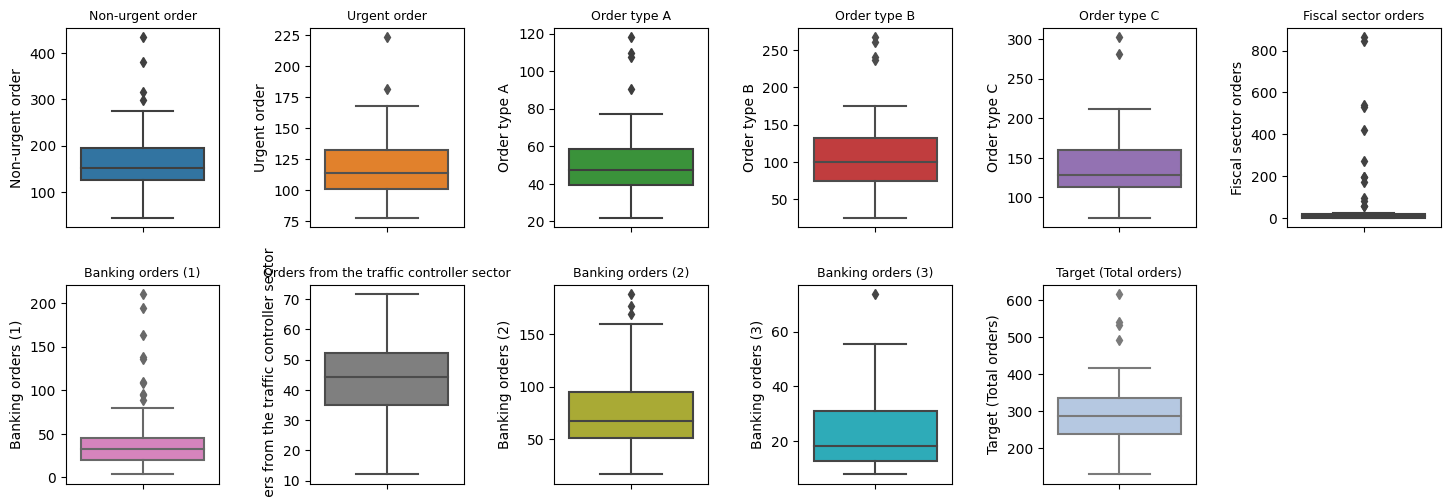

In [5]:
columnas = ['Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 'Order type C',
           'Fiscal sector orders', 'Banking orders (1)', 'Orders from the traffic controller sector',
           'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)']

f, axes = plt.subplots(3, 6, figsize=(15, 8))

axes = axes.flatten()

def create_boxplot_styled(columnas, ax, color):
    sns.boxplot(y=columnas, data=df, ax=ax, color=color)
    ax.set_title(columnas, fontsize=9)
    ax.set_xlabel("")

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
          "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8"]

for i, col in enumerate(columnas):
    create_boxplot_styled(col, axes[i], colors[i])

for i in range(len(columnas), len(axes)):
    f.delaxes(axes[i])

plt.tight_layout(pad=2.5)

plt.show()

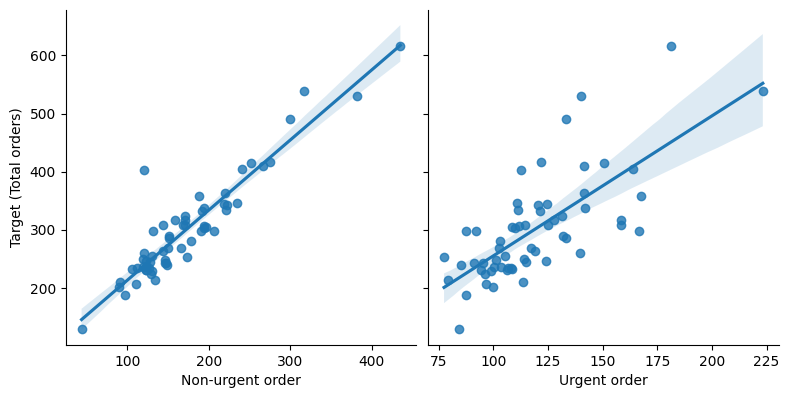

In [ ]:
sns.pairplot(x_vars=['Non-urgent order', 'Urgent order'], y_vars='Target (Total orders)', height=4, aspect=1, kind='reg', data=df)
plt.show()

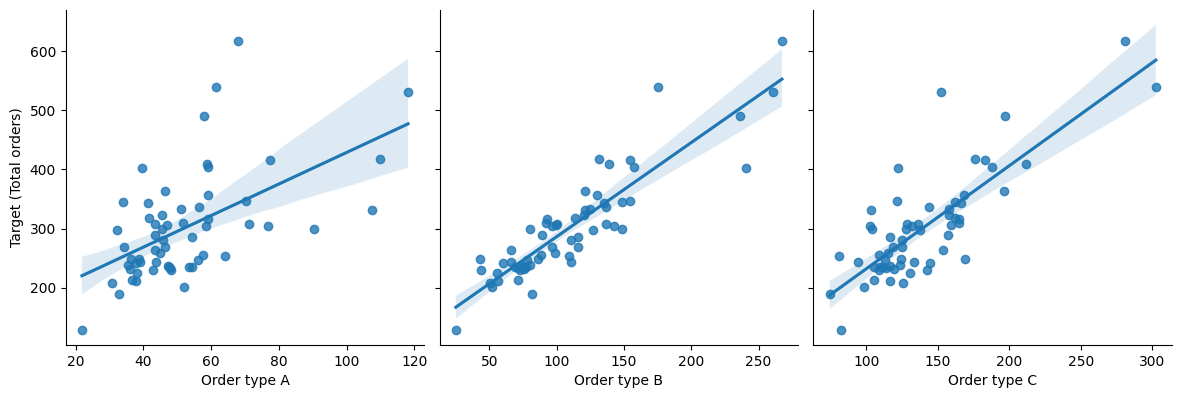

In [ ]:
sns.pairplot(x_vars=['Order type A', 'Order type B', 'Order type C'], y_vars='Target (Total orders)', height=4, aspect=1, kind='reg', data=df)
plt.show()

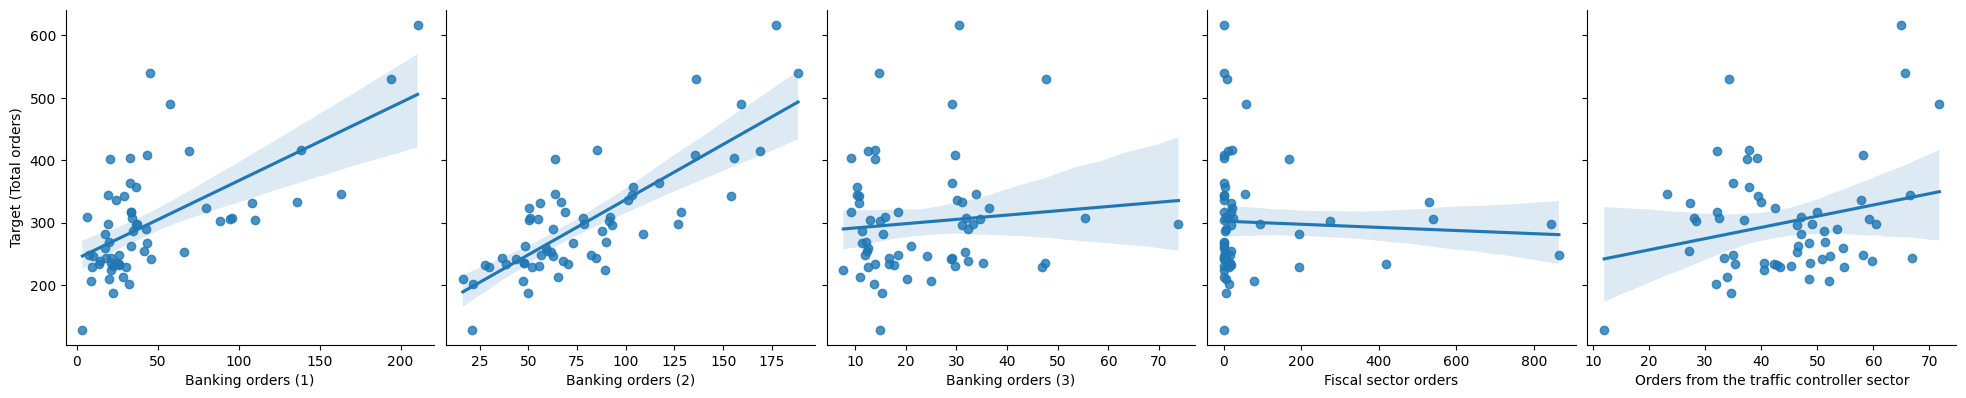

In [ ]:
sns.pairplot(x_vars=['Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)', 'Fiscal sector orders', 'Orders from the traffic controller sector'], y_vars='Target (Total orders)', height=4, aspect=1, kind='reg', data=df)
plt.show()

In [ ]:
df.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)', 'date_logistic'],
      dtype='object')

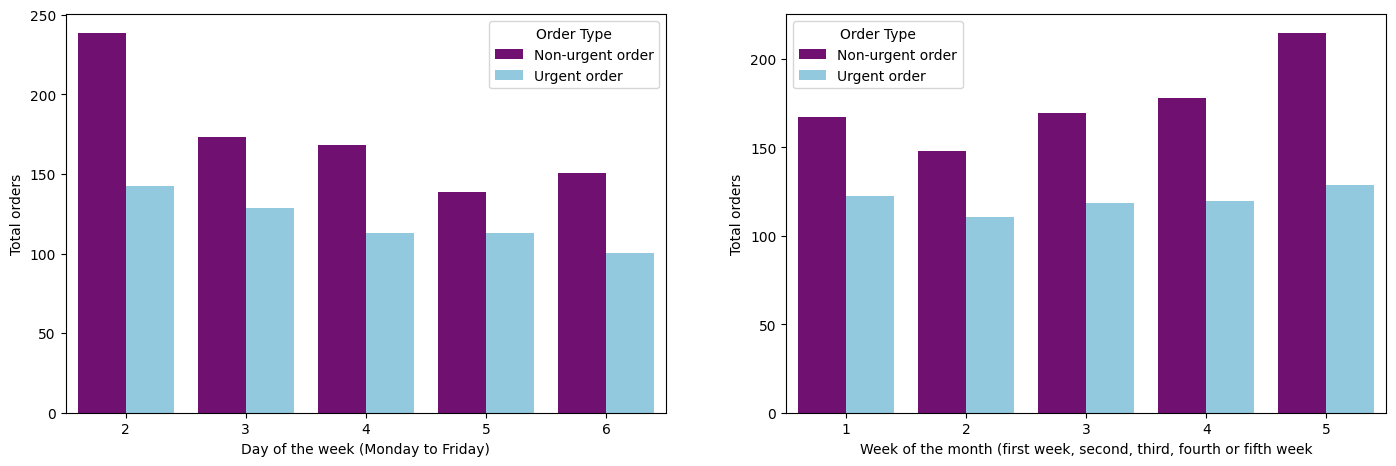

In [ ]:
plt.figure(figsize = (110,30))
df_melted = df.melt(id_vars=['Day of the week (Monday to Friday)', 'Week of the month (first week, second, third, fourth or fifth week'], value_vars=['Non-urgent order', 'Urgent order'], var_name='Order Type', value_name='Total orders')
plt.subplot(5,12,1)
sns.barplot(x='Day of the week (Monday to Friday)', y='Total orders', hue='Order Type', data=df_melted, palette=['purple', 'skyblue'], ci=None)
plt.subplot(5,12,2)
sns.barplot(x='Week of the month (first week, second, third, fourth or fifth week', y='Total orders', hue='Order Type', data=df_melted, palette=['purple', 'skyblue','pink'], ci=None)
plt.show()

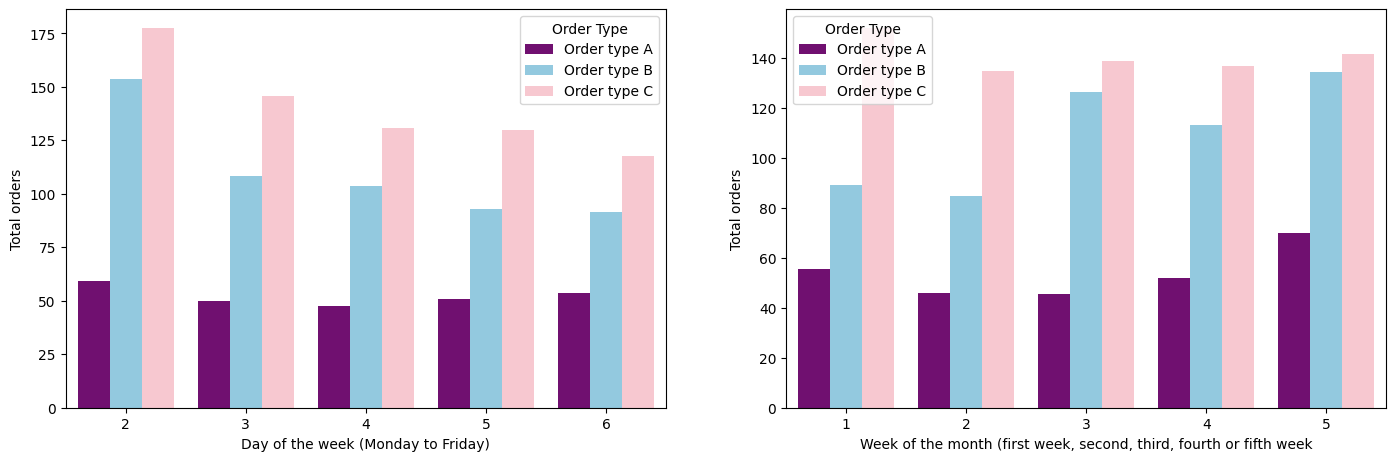

In [ ]:
plt.figure(figsize = (110,30))
df_melted = df.melt(id_vars=['Day of the week (Monday to Friday)', 'Week of the month (first week, second, third, fourth or fifth week'], value_vars=['Order type A', 'Order type B', 'Order type C'], var_name='Order Type', value_name='Total orders')
plt.subplot(5,12,1)
sns.barplot(x='Day of the week (Monday to Friday)', y='Total orders', hue='Order Type', data=df_melted, palette=['purple', 'skyblue','pink'], ci=None)
plt.subplot(5,12,2)
sns.barplot(x='Week of the month (first week, second, third, fourth or fifth week', y='Total orders', hue='Order Type', data=df_melted, palette=['purple', 'skyblue','pink'], ci=None)
plt.show()

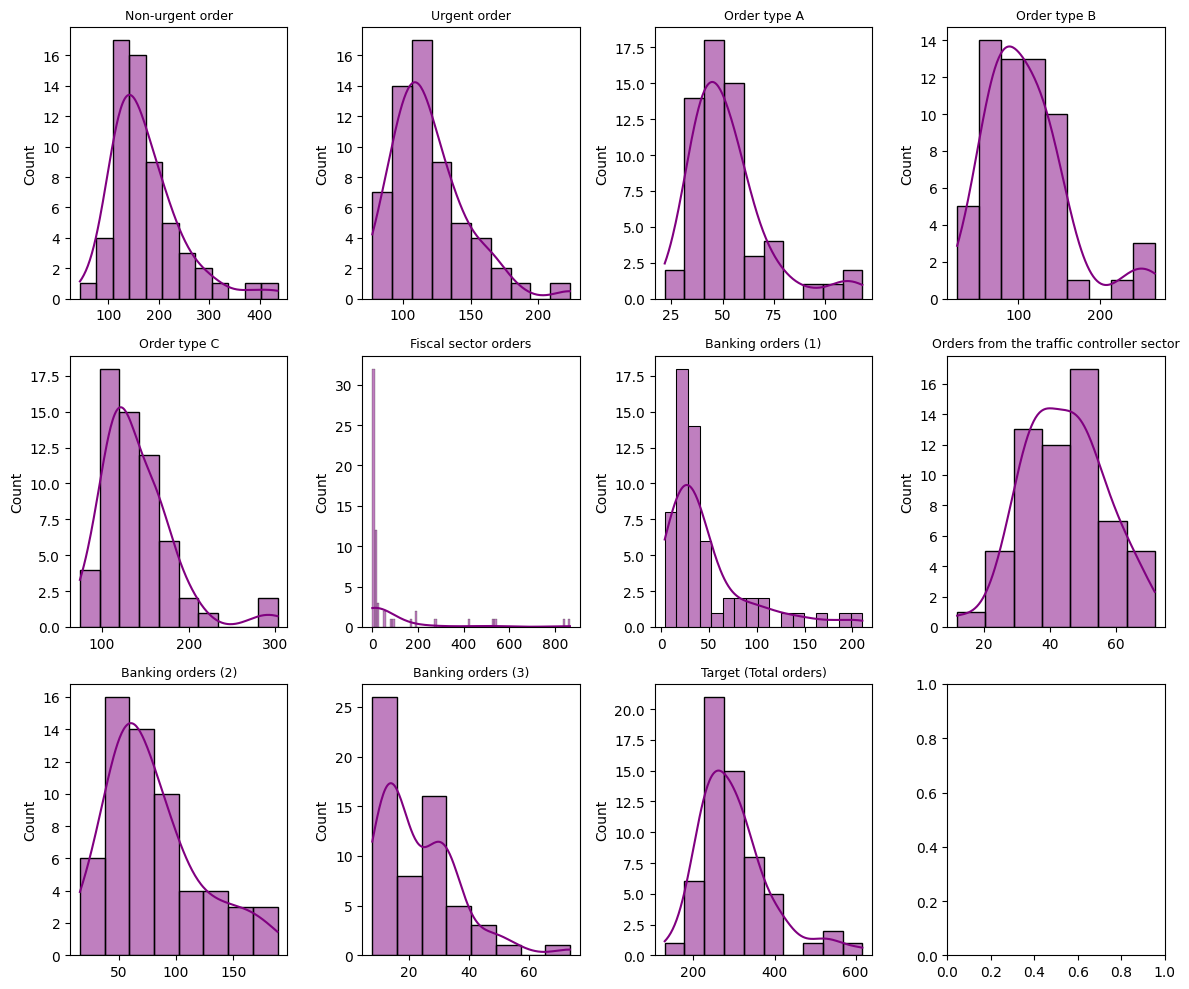

In [ ]:
columnas = ['Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 'Order type C',
           'Fiscal sector orders', 'Banking orders (1)', 'Orders from the traffic controller sector',
           'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)']

fig, axes = plt.subplots(3, 4, figsize=(12, 10))

axes = axes.flatten()

def plot_histogram(col, ax):
    sns.histplot(data=df, x=col, kde=True, ax=ax, color='purple')
    ax.set_title(col, fontsize=9)
    ax.set_xlabel("")

[plot_histogram(col, ax) for col, ax in zip(columnas, axes)]

plt.tight_layout()
plt.show()

#<font color='red'>Correlation Heatmap</font>

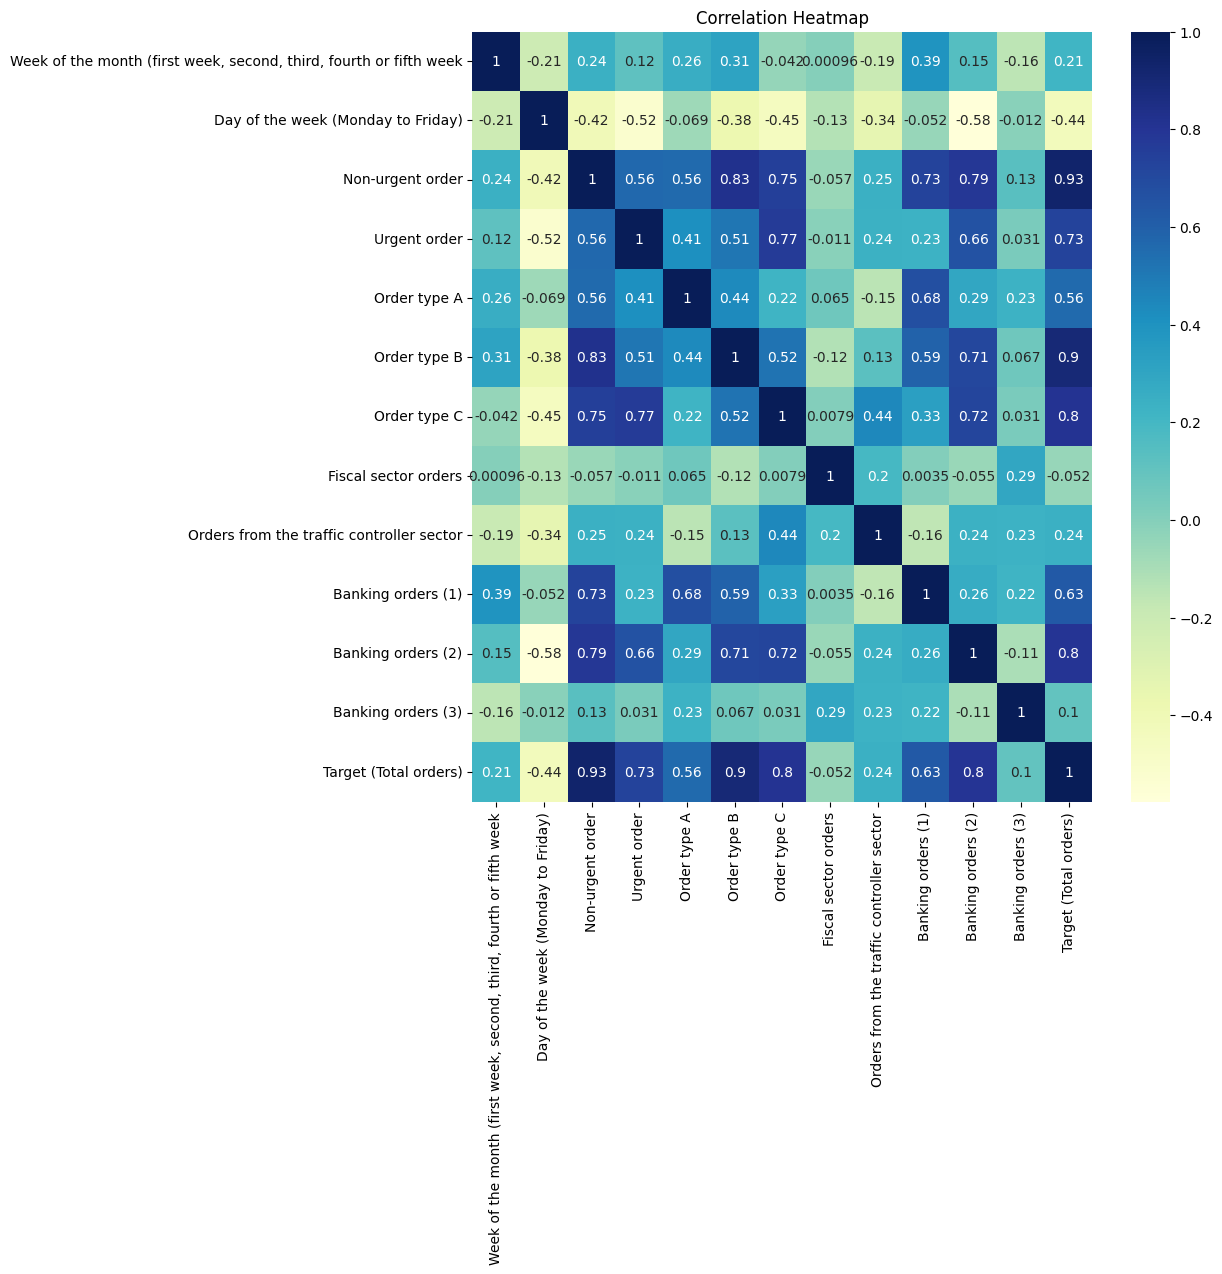

In [ ]:
plt.figure(figsize=[10,10])
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)
plt.title('Correlation Heatmap')
plt.show()

# <font color='red'>Feature Selection</font>

## Removing the collinear Features by taking the correlation threshold as 0.75


In [ ]:
# corr_matrix = df.corr().abs()
# # print(corr_matrix)
# high_corr_pairs = np.where(corr_matrix > 0.75)
# (high_corr_pairs)

(array([ 0,  1,  2,  2,  2,  2,  2,  3,  3,  4,  5,  5,  5,  6,  6,  6,  6,
         7,  8,  9, 10, 10, 10, 11, 12, 12, 12, 12, 12]),
 array([ 0,  1,  2,  5,  6, 10, 12,  3,  6,  4,  2,  5, 12,  2,  3,  6, 12,
         7,  8,  9,  2, 10, 12, 11,  2,  5,  6, 10, 12]))

In [ ]:
# # Create a mask to identify which columns to keep and which to drop
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
# mask

array([[False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True],
       [False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True],
       [False, False, False,

In [ ]:
# # Remove one column from each pair of highly correlated columns
# columns_to_drop = set()
# for col1, col2 in zip(*high_corr_pairs):
#     if col1 != col2 and mask[col1, col2]:
#         col_to_drop = corr_matrix.columns[col2]  # Choose which column to drop
#         columns_to_drop.add(col_to_drop)

# columns_to_drop

# # # Drop the identified columns from the DataFrame
# # df = df.drop(columns=columns_to_drop, axis=1)
# columns_to_drop.remove('Target (Total orders)')
# print(columns_to_drop)

# Drop the identified columns from the DataFrame
# df_columns_to_remove = df.drop(columns=columns_to_drop, axis=1)

# print(df_columns_to_remove.columns)

### Checking the VIF (Variance Infalation Factor)for each features first on all Features we saw that there are some high values but after filtering out some of the correlated features we calculates the VIF again now its comparatively lower than the previous values.


In [12]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df is your DataFrame with features and the target variable
# Separate the features and the target variable
X = df.drop(columns=['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)','Target (Total orders)'])  # Features
y = df['Target (Total orders)']  # Target variable

# Calculate VIF for each feature column
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                                     Feature         VIF
0                           Non-urgent order  380.700600
1                               Urgent order  125.325395
2                               Order type A   31.266992
3                               Order type B   27.337046
4                               Order type C  137.243964
5                       Fiscal sector orders    1.653362
6  Orders from the traffic controller sector   32.947215
7                         Banking orders (1)   26.602527
8                         Banking orders (2)   66.514774
9                         Banking orders (3)    5.927279


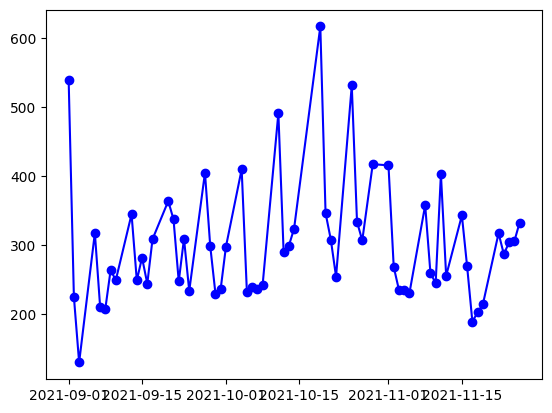

In [111]:
plt.plot(df['date_logistic'], df['Target (Total orders)'], label='Actual - Training', color='blue', marker='o')

# <font color='red'>Extracting The Day , Month seperately to add them as time series columns</font>


In [6]:
df['Day(date of the month)']= df['date_logistic'].apply(lambda x:x.day)
df['Month']= df['date_logistic'].apply(lambda x:x.month)

# <font color='red'>APPROACH ---- 1 ======></font>

### In which I am taking features columns as "WEEK OF THE MONTH","DAY OF WEEK","DAY(date of the month)","Month" and will predict every other features by taking them as Target

## 1st Feature sets to observe

In [55]:
# columns_to_keep_as_features = ['Week of the month (first week, second, third, fourth or fifth week', 'Day of the week (Monday to Friday)', 'Day(date of the month)','Month']
# df_final = df[columns_to_keep_as_features]

## 2nd Feature sets to observe

In [ ]:
# columns_to_keep_as_features_2=[ 'Day(date of the month)']
# df_final=df[columns_to_keep_as_features_2]

## 3rd Feature sets to observe

In [7]:
columns_to_keep_as_features = ['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)']
df_final = df[columns_to_keep_as_features]


# <font color='red'> Dropping the column "Fiscal Sector" as its having more outlier in the scatter plot</font>


In [ ]:
sns.pairplot(x_vars=['Fiscal sector orders'], y_vars='Target (Total orders)', height=4, aspect=1, kind='reg', data=df)
plt.show()

In [8]:
demand_df=df
print(demand_df.columns)

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)', 'date_logistic', 'Day(date of the month)',
       'Month'],
      dtype='object')



# <font color='red'>Splitting Data into Train and Test :-</font>


In [9]:
##df_final contains input features, demand_df contains full dataset

train_percentage=80
train_final_index=round(len(df_final)*(train_percentage/100))
X_train, X_test = df_final[0:train_final_index], df_final[train_final_index:]
y_train, y_test = demand_df[['Target (Total orders)']][0:train_final_index], demand_df[['Target (Total orders)']][train_final_index:]


# <font color='red'>Lasso Regression Implementation :-</font>


In [10]:
##Application of Regression model( Lasso Regression ) and printing error metrics


from sklearn.metrics import explained_variance_score
lasso_reg = Lasso(alpha=10)
lasso_reg.fit(X_train, y_train)
joblib.dump(lasso_reg, "lasso_reg.h5")
y_pred = lasso_reg.predict(X_test)
print('RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 score -> ', r2_score(y_test, y_pred))
print('Explained Variance Score:', explained_variance_score(y_test, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE:', mean_absolute_percentage_error(y_test.values, y_pred))
print(y_pred)

RMSE : 4.748563277977918
R2 score ->  0.9937876564143693
Explained Variance Score: 0.9941629486037623
MAPE: 24.924281925178793
[386.85753297 253.51302902 344.11002154 270.12980254 189.85722351
 200.94331648 215.0338135  316.43276875 286.84371992 304.87917907
 304.9590037  329.03902814]



# <font color='red'>Neural Network Approach like by using MLP and DNN</font>


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Initialize MLP Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 200), activation='relu', solver='lbfgs', random_state=42)
mlp_regressor.fit(X_train, y_train)
y_pred = mlp_regressor.predict(X_test)

# Evaluation
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R2 score:', r2_score(y_test, y_pred))
print('Explained Variance Score:', explained_variance_score(y_test, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print(y_pred)


RMSE: 2.3221566377145195
R2 score: 0.9985143584740874
Explained Variance Score: 0.9986662424816509
MAPE: 25.187562178286555
[395.02493468 254.79075239 341.82605785 268.58735696 188.2920057
 201.55132322 212.64639243 317.69171265 286.49105036 305.36962331
 304.38615328 331.03675901]


In [ ]:
# MLP Regressor with 7 hidden layers, 25 neurons per layer, and 1000 iterations
mlp_regressor = MLPRegressor(hidden_layer_sizes=(25, 25, 25, 25, 25, 25, 25), max_iter=1000)
mlp_regressor.fit(X_train, y_train)
y_pred = mlp_regressor.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")
print('Explained Variance Score:', explained_variance_score(y_test, y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print(y_pred)

RMSE: 11.890877570453089
R2 score: 0.9610453933735217
Explained Variance Score: 0.9636775222448769
MAPE: 24.305780391515196
[363.70537822 255.08182209 347.8463033  267.88685964 189.07918739
 203.16202084 215.89701885 314.35439937 284.64762915 311.95482391
 301.26570655 324.63178457]



# <font color='red'> LSTM Approach.</font>
## Hyperparameter Tuning using GridSearchCV





In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, RegressorMixin



# Convert DataFrames to arrays (if needed)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalizing the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape to 2D for scaling
X_train_2d = X_train.reshape(-1, X_train.shape[1])
X_test_2d = X_test.reshape(-1, X_test.shape[1])

X_train_scaled = scaler_x.fit_transform(X_train_2d)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Reshape back to 3D for LSTM input
X_train_scaled_3d = X_train_scaled.reshape((X_train_scaled.shape[0], X_train.shape[1], 1))

# Define a class that wraps the Keras model to behave like a scikit-learn estimator
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.001, units=20, epochs=150, batch_size=64, verbose=0):
        self.learning_rate = learning_rate
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = Sequential()
        self.model.add(LSTM(self.units, input_shape=(X.shape[1], X.shape[2])))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=self.learning_rate))

        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define the hyperparameters grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1,0.3,0.5,0.001,1],
    'units': [10, 20],
    'epochs': [100,200],
    'batch_size': [32, 64, 128]
}

# Create the wrapper object
keras_wrapper = KerasRegressorWrapper()

# Perform GridSearchCV
grid = GridSearchCV(estimator=keras_wrapper, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train_scaled_3d, y_train_scaled)

# Get the best parameters and best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Get the best model
best_model = grid_result.best_estimator_

# Preprocess test data and make predictions using the best model
X_test_scaled = scaler_x.transform(X_test_2d)
X_test_scaled_3d = X_test_scaled.reshape((X_test_scaled.shape[0], X_test.shape[1], 1))
y_pred_scaled = best_model.predict(X_test_scaled_3d)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Evaluate the best model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 score: {r2}")



#<font color='red'> All Regression Techniques at a time using GridSearchCV.</font>



In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


# List of regressor models
models = [
    LinearRegression(),
    Lasso(alpha=10),
    Ridge(alpha=10),
    DecisionTreeRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=13, subsample=0.1),

]

for model in models:
    if isinstance(model, XGBRegressor):
        # Hyperparameters to tune for XGBoost
        param_grid = {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.05, 0.1, 0.3,0.01,0.001,0.7,0.8],
            'max_depth': [3, 5, 7,10,18,30,50,100],
            'subsample': [0.6, 0.8, 1.0,0.01,0.001,2,5,10]
        }

        # Perform Grid Search to find the best hyperparameters
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        # Get the best estimator after Grid Search
        best_estimator = grid_search.best_estimator_
        # print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
        # Fit the best model on the entire training set
        best_estimator.fit(X_train, y_train)

        # Make predictions and evaluate
        y_pred = best_estimator.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{model.__class__.__name__}:")
        print(f"RMSE: {rmse}")
        print(f"R2 score: {r2}")
        print('Explained Variance Score:', explained_variance_score(y_test, y_pred))

        def mean_absolute_percentage_error(y_true, y_pred):
          return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        print('MAPE:', mean_absolute_percentage_error(y_test.values, y_pred))
        print("-" * 30)

    else:
        # For other models, continue as before
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{model.__class__.__name__}:")
        print(f"RMSE: {rmse}")
        print(f"R2 score: {r2}")
        print('Explained Variance Score:', explained_variance_score(y_test, y_pred))

        def mean_absolute_percentage_error(y_true, y_pred):
          return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        print('MAPE:', mean_absolute_percentage_error(y_test.values, y_pred))
        print("-" * 30)


LinearRegression:
RMSE: 9.568173158301911e-14
R2 score: 1.0
Explained Variance Score: 1.0
MAPE: 2.7515731882837764e-14
------------------------------
Lasso:
RMSE: 4.748563277977918
R2 score: 0.9937876564143693
Explained Variance Score: 0.9941629486037623
MAPE: 24.924281925178793
------------------------------
Ridge:
RMSE: 0.3026498181819135
R2 score: 0.9999747645041491
Explained Variance Score: 0.9999781289890484
MAPE: 0.03934966965291496
------------------------------
DecisionTreeRegressor:
RMSE: 44.86763850482886
R2 score: 0.4453775663405014
Explained Variance Score: 0.49835180452207883
MAPE: 24.548789798017744
------------------------------
GradientBoostingRegressor:
RMSE: 42.293711456861864
R2 score: 0.5071864912405628
Explained Variance Score: 0.5079450161066019
MAPE: 22.711222715713003
------------------------------
best_estimator:   XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytre


#<font color='red'>Taking Lasso Regression for forecasting the next 30 days of every features</font>


## Code for taking lasso regression on whole columns as features

RMSE - Train: 81.05758645346033
R2 score - Train: 0.2600480490473105
RMSE - Test: 70.18774794731193
R2 score - Test: -0.35723054019603495


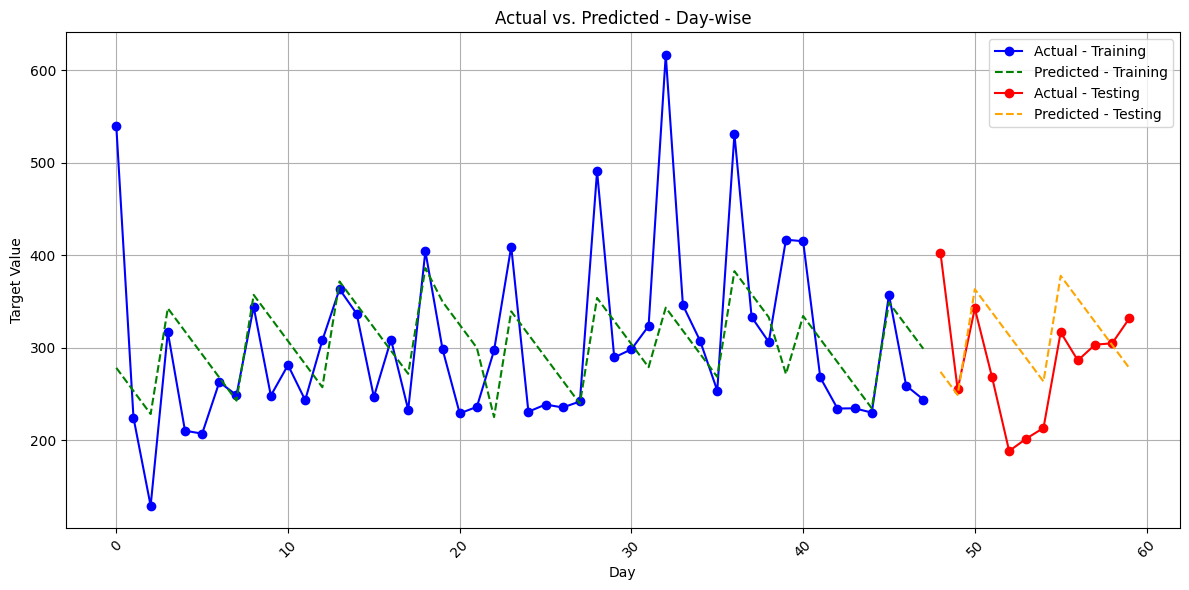

In [58]:

############## Code for taking lasso regression on whole columns as feartures ########################

lasso_reg = Lasso(alpha=10)
lasso_reg.fit(X_train, y_train)

# Predictions on training and testing data
y_pred_train = lasso_reg.predict(X_train)
y_pred_test = lasso_reg.predict(X_test)

# Calculate RMSE and R2 scores for training and testing data
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print('RMSE - Train:', rmse_train)
print('R2 score - Train:', r2_train)
print('RMSE - Test:', rmse_test)
print('R2 score - Test:', r2_test)


plt.figure(figsize=(12, 6))

# Plotting training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o')
plt.plot(y_train.index, y_pred_train, label='Predicted - Training', color='green', linestyle='dashed')

# Plotting testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='red', marker='o')
plt.plot(y_test.index, y_pred_test, label='Predicted - Testing', color='orange', linestyle='dashed')

plt.title('Actual vs. Predicted - Day-wise')
plt.xlabel('Day')
plt.ylabel('Target Value')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#<font color='red'>Training & Testing dataset comparison between predicted and actual using only day, month , week as features columns</font>


RMSE - Train: 81.05758645346033
R2 score - Train: 0.2600480490473105
RMSE - Test: 70.18774794731193
R2 score - Test: -0.35723054019603495


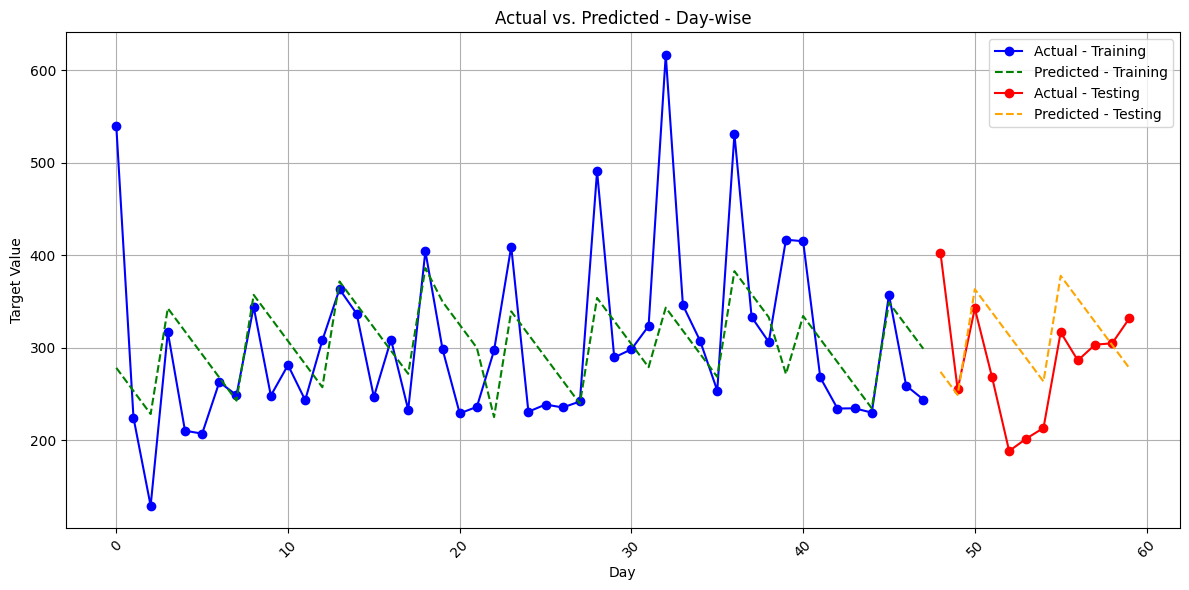

In [100]:

lasso_reg = Lasso(alpha=10)
lasso_reg.fit(X_train, y_train)

# Predictions on training and testing data
y_pred_train = lasso_reg.predict(X_train)
y_pred_test = lasso_reg.predict(X_test)

# Calculate RMSE and R2 scores for training and testing data
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print('RMSE - Train:', rmse_train)
print('R2 score - Train:', r2_train)
print('RMSE - Test:', rmse_test)
print('R2 score - Test:', r2_test)


plt.figure(figsize=(12, 6))

# Plotting training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o')
plt.plot(y_train.index, y_pred_train, label='Predicted - Training', color='green', linestyle='dashed')

# Plotting testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='red', marker='o')
plt.plot(y_test.index, y_pred_test, label='Predicted - Testing', color='orange', linestyle='dashed')

plt.title('Actual vs. Predicted - Day-wise')
plt.xlabel('Day')
plt.ylabel('Target Value')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
df.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)', 'date_logistic', 'date',
       'Day(date of the month)', 'Month'],
      dtype='object')

# <font color='red'>Forecasting Next 30 days values :-</font>


In [68]:
# Forecast next 30 days
df['date'] = pd.to_datetime(df['date_logistic'])

# Get the last date in the 'date' column
last_date = df['date'].max()

next_30_days = pd.date_range(last_date + pd.DateOffset(days=1), periods=30, freq='B')
print(next_30_days)

next_30_dates = pd.date_range(start='2021-11-26', periods=30)  # Example date range

# DataFrame with extracted date-related columns for the next 30 days
next_30_dates_df = pd.DataFrame()
next_30_dates_df['Week of the month (first week, second, third, fourth or fifth week'] = next_30_dates.weekofyear
# next_30_dates_df['Day of the week (Monday to Friday)'] = next_30_dates.dayofweek

next_30_dates_df['Day of the week (Monday to Friday)'] = (next_30_dates_df['Day of the week (Monday to Friday)'] + 1) % 7 + 1

next_30_dates_df['Day(date of the month)'] = next_30_dates.day
next_30_dates_df['Month'] = next_30_dates.month
print(next_30_dates_df['Day of the week (Monday to Friday)'].values)

forecast_df = pd.DataFrame({'Forecasted_values': next_30_dates_df['Day of the week (Monday to Friday)'].values})

# Write the DataFrame to an Excel file without the index
forecast_df.to_excel('file_path.xlsx', index=False)

predicted_next_30_days = lasso_reg.predict(next_30_dates_df)
# Displaying the predicted output for the next 30 days
print(predicted_next_30_days)

new_index = np.arange(60, 90)
# Setting the new index to the DataFrame
next_30_dates_df.index = new_index
next_30_dates_df



DatetimeIndex(['2021-11-29', '2021-11-30', '2021-12-01', '2021-12-02',
               '2021-12-03', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07'],
              dtype='datetime64[ns]', freq='B')


KeyError: ignored

#<font color='red'> Plotting Training , Testing , Forecasted Target Data w.r.t date :---</font>


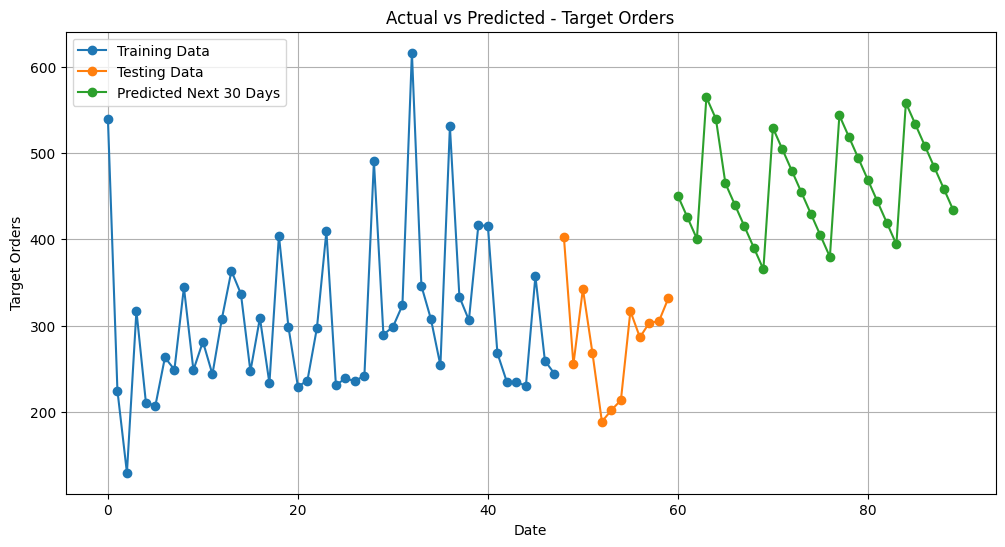

In [104]:
# Plotting the training and testing data
plt.figure(figsize=(12, 6))

# Plotting training data
plt.plot(y_train.index, y_train, label='Training Data', marker='o', linestyle='-')

# Plotting testing data
plt.plot(y_test.index, y_test, label='Testing Data', marker='o', linestyle='-')

# Plotting predicted next 30 days data
plt.plot(next_30_dates_df.index, predicted_next_30_days, label='Predicted Next 30 Days', marker='o', linestyle='-')

plt.title('Actual vs Predicted - Target Orders')
plt.xlabel('Date')
plt.ylabel('Target Orders')
plt.legend()
plt.grid()
plt.show()


#**Time Series Forecasting Models**


# <font color='red'> By using HWES we are forecasting the next 30 days of total orders</font>


RMSE: 61.433096269074966
R2 score: -0.03976649092696816
Empty DataFrame
Columns: []
Index: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
    Target (Total orders)
60               5.682874
61               5.634463
62               5.593477
63               5.859930
64               5.632722
65               5.682874
66               5.634463
67               5.593477
68               5.859930
69               5.632722
70               5.682874
71               5.634463
72               5.593477
73               5.859930
74               5.632722
75               5.682874
76               5.634463
77               5.593477
78               5.859930
79               5.632722
80               5.682874
81               5.634463
82               5.593477
83               5.859930
84               5.632722
85               5.682874
86               5.634463
87               5.593477
88               5.859930
89      

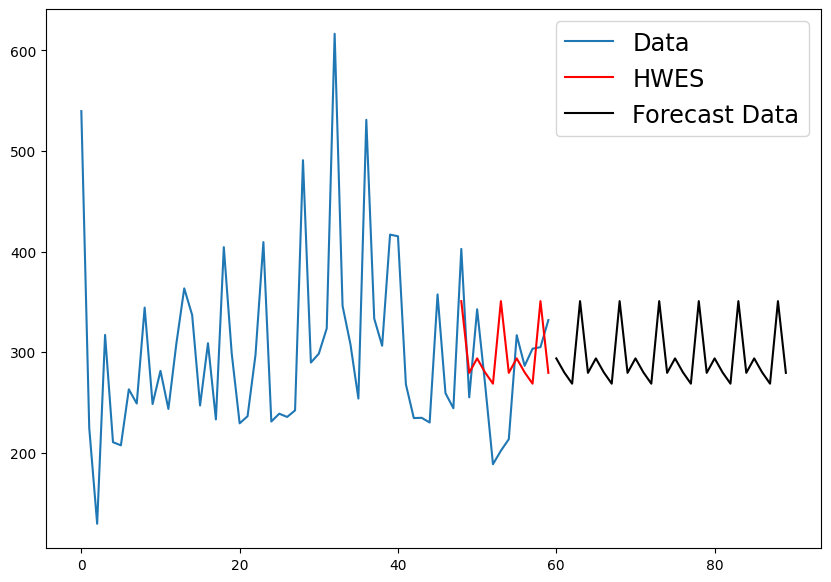

In [ ]:
# Log scaling the 'Target (Total orders)' column
df_log = np.log(demand_df['Target (Total orders)'])

# Splitting data into train and test sets (80-20 split)
train_percentage = 80
train_final_index = round(len(df_log) * (train_percentage / 100))
train_data, test_data = df_log[0:train_final_index], df_log[train_final_index:]

# HWES model with seasonality of 5 days
def HWES_model(train, test):
    model = ExponentialSmoothing(train, seasonal='multiplicative', seasonal_periods=5)
    model_fit = model.fit()

    joblib.dump(model_fit, "timeseries_hotwinter_uni.h5")
    yhat = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
    # print(yhat)
    res = pd.DataFrame({"Pred": yhat, "Act": np.exp(test)})  # Back-transforming predictions
    # print(res)
    return model_fit, res

# Calculate error metrics and forecast for next 7 days
model_hwes, df_ret = HWES_model(train_data, test_data)
exp_pred_holt = np.exp(df_ret['Pred'])
exp_test = df_ret['Act']

# Calculate and print error metrics
print('RMSE:', np.sqrt(mean_squared_error(exp_test, exp_pred_holt)))
print('R2 score:', r2_score(exp_test, exp_pred_holt))

##Forecasting for next 30 days
extra_dates = [test_data.index[-1] + d for d in range (1,31)]
forecast_hwes_df = pd.DataFrame(index=extra_dates)
print(forecast_hwes_df)
forecast_hwes_df['Target (Total orders)'] = model_hwes.predict(start=forecast_hwes_df.index[0], end=forecast_hwes_df.index[-1])
print(forecast_hwes_df)

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(demand_df.index, demand_df['Target (Total orders)'], label='Data')
plt.plot(test_data.index, exp_pred_holt, label='HWES', color='r')
plt.plot(forecast_hwes_df.index, np.exp(forecast_hwes_df['Target (Total orders)']), color='black', label='Forecast Data')
plt.legend(loc='best', fontsize='xx-large')
plt.show()


# <font color='red'>Using ARIMA</font>

R-squared (R2) Score: -0.2290
Root Mean Squared Error (RMSE): 101.2321
Mean Absolute Error (MAE): 70.1288
Mean Absolute Percentage Error (MAPE): 22.3970%


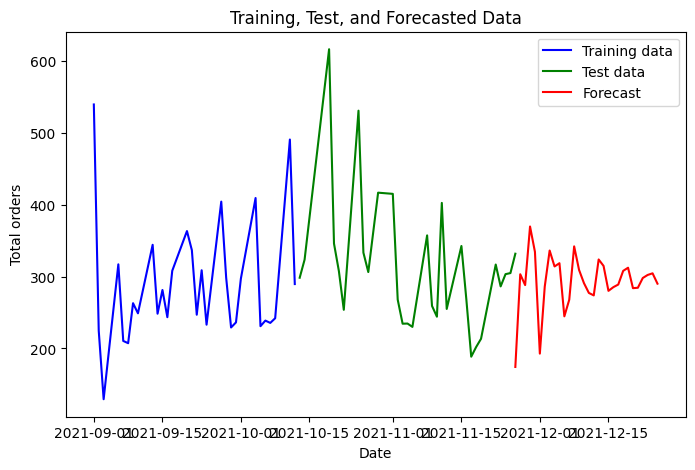

In [13]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df contains your dataset
# Selecting relevant columns
data = df[['Week of the month (first week, second, third, fourth or fifth week','Day of the week (Monday to Friday)', 'Non-urgent order', 'Urgent order',
           'Order type A', 'Order type B', 'Order type C', 'Fiscal sector orders',
           'Orders from the traffic controller sector', 'Banking orders (1)',
           'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)', 'date_logistic']]

# Splitting data into train and test sets
train = data.iloc[:30]  # Assuming the last 30 days are for validation
test = data.iloc[30:]

# Fitting ARIMA model
model = ARIMA(train['Target (Total orders)'], order=(5,1,0))
model_fit = model.fit()

# Forecasting for the next 30 days
forecast = model_fit.forecast(steps=30)

# Calculate evaluation metrics
r2 = r2_score(test['Target (Total orders)'], forecast)
rmse = mean_squared_error(test['Target (Total orders)'], forecast, squared=False)
mae = mean_absolute_error(test['Target (Total orders)'], forecast)
mape = 100 * (mae / test['Target (Total orders)'].mean())

# Print evaluation metrics
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


# Plotting training, test, and forecasted data
plt.figure(figsize=(8, 5))

# Plot training data
plt.plot(train['date_logistic'], train['Target (Total orders)'], label='Training data', color='blue')

# Plot test data
plt.plot(test['date_logistic'], test['Target (Total orders)'], label='Test data', color='green')

# Plotting forecasted data 30 days ahead of the test data
forecast_dates = pd.date_range(start=test['date_logistic'].iloc[-1], periods=30) # Assuming daily forecast for next 30 days
forecast_end_date = forecast_dates[-1]  # Get the last date in the forecast range
forecast_start_date = forecast_end_date + pd.Timedelta(days=1)  # Get the start date for the forecast range
forecast_range = pd.date_range(start=forecast_start_date, periods=30)  # Generate dates for the forecast range
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
# print(forecast_dates)
plt.xlabel('Date')
plt.ylabel('Total orders')
plt.title('Training, Test, and Forecasted Data')
plt.legend()
plt.show()


#<font color='red'> Using SARIMAX we are forecasting the next 30 days of total orders</font>


## Univariate as well as Multivariate  Timeseries Forecasting


# <font color='red'>Univariate One</font>

RMSE: 71.26669953648661
R2 score: -0.3992789497503215
Mean Absolute Error (MAE): 53.4735
Mean Absolute Percentage Error (MAPE): 18.7813%


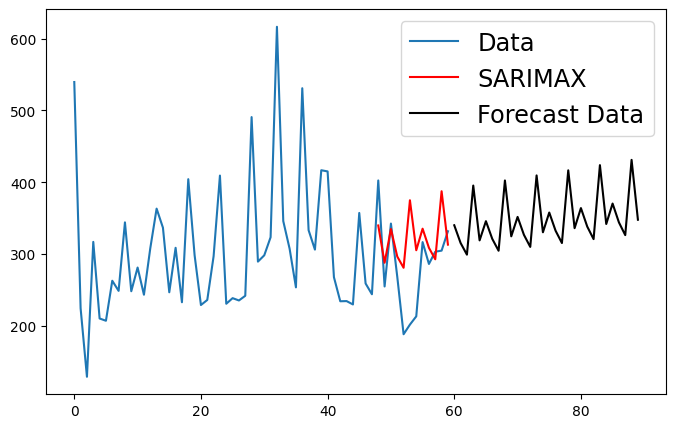

In [11]:
demand_df=df
# Log scaling the 'Target (Total orders)' column
df_log = np.log(demand_df['Target (Total orders)'])

# Splitting data into train and test sets (80-20 split)
train_percentage = 80
train_final_index = round(len(df_log) * (train_percentage / 100))
train_data, test_data = df_log[0:train_final_index], df_log[train_final_index:]

# SARIMA model with seasonal parameters
def SARIMA_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 5))
    model_fit = model.fit()

    joblib.dump(model_fit, "timeseries_sarima_model.pkl")
    yhat = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
    res = pd.DataFrame({"Pred": yhat, "Act": np.exp(test)})  # Back-transforming predictions
    return model_fit, res

# Calculate error metrics and then forecast for next 30 days
model_sarima, df_ret = SARIMA_model(train_data, test_data)
exp_pred_sarima = np.exp(df_ret['Pred'])
exp_test = df_ret['Act']

# Calculate and print error metrics
print('RMSE:', np.sqrt(mean_squared_error(exp_test, exp_pred_sarima)))
print('R2 score:', r2_score(exp_test, exp_pred_sarima))
mae = mean_absolute_error(exp_test, exp_pred_sarima)
mape = 100 * (mae / exp_test.mean())
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


# Forecasting for the next 30 days
forecast_dates = [test_data.index[-1] + d for d in range (1,31)]
# forecast_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
forecast_sarima_df = pd.DataFrame(index=forecast_dates)
forecast_sarima_df['Target (Total orders)'] = model_sarima.predict(start=forecast_sarima_df.index[0], end=forecast_sarima_df.index[-1])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(demand_df.index, demand_df['Target (Total orders)'], label='Data')
plt.plot(test_data.index, exp_pred_sarima, label='SARIMAX', color='r')
plt.plot(forecast_sarima_df.index, np.exp(forecast_sarima_df['Target (Total orders)']), color='black', label='Forecast Data')
plt.legend(loc='best', fontsize='xx-large')
plt.show()



# <font color='red'>Multivariate One</font>

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[303.71280434 326.61866898 601.52969965 314.82292334 279.2444246
 233.75445306 464.78915579 323.52243457 309.51939975 344.83073279
 399.22697711 277.22774409 242.80948284 240.97178973 229.62643942
 369.53603768 293.94912117 271.69751674 406.23159388 246.02150646
 358.68001829 305.17446688 214.19120056 206.30788436 220.24927712
 334.57121289 313.69342905 306.61497602 283.52660062 283.01414354]
R-squared (R2) Score: 0.9161
Root Mean Squared Error (RMSE): 26.4505
Mean Absolute Error (MAE): 19.6302
Mean Absolute Percentage Error (MAPE): 6.2693%


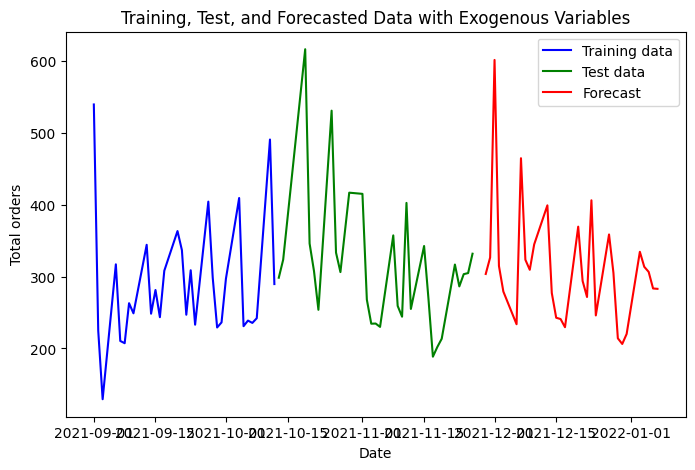

In [34]:

# Assuming df contains your dataset
data = df[['Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)',
       'Target (Total orders)', 'date_logistic']]

# Splitting data into train and test sets
train = data.iloc[:30]  # Assuming the last 30 days are for validation
# print(train)
test = data.iloc[30:]
# print(test)

# Fitting SARIMAX model
model = SARIMAX(endog=train[ 'Target (Total orders)'],
                exog=train[[ 'Urgent order', 'Order type B', 'Order type C',
       'Orders from the traffic controller sector',
    'Banking orders (2)']],
                order=(1, 1, 1),  # Example ARIMA order, can be tuned
                seasonal_order=(1, 1, 1, 5))  # Example seasonal order, can be tuned
model_fit = model.fit()

# Forecasting for the next 30 days
forecast = model_fit.get_forecast(steps=30, exog=test[[ 'Urgent order', 'Order type B', 'Order type C',
        'Orders from the traffic controller sector', 'Banking orders (2)']])
forecast_values = forecast.predicted_mean
print(forecast_values.values)
# forecast_df = pd.DataFrame({'Forecasted_values': forecast_values.values})
# # Write the DataFrame to an Excel file without the index
# forecast_df.to_excel('file_path.xlsx', index=False)


# Creating date range for forecast period starting 30 days ahead from the last date in the test set
last_test_date = test['date_logistic'].iloc[-1]
forecast_dates = pd.date_range(start=last_test_date + pd.DateOffset(days=1), periods=30,freq='B')


# Calculate evaluation metrics
r2 = r2_score(test[  'Target (Total orders)'], forecast_values)
rmse = mean_squared_error(test[  'Target (Total orders)'], forecast_values, squared=False)
mae = mean_absolute_error(test[ 'Target (Total orders)'], forecast_values)
mape = 100 * (mae / test[  'Target (Total orders)'].mean())

# Print evaluation metrics
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")




# Plotting training, test, and forecasted data
plt.figure(figsize=(8, 5))
plt.plot(train['date_logistic'], train[  'Target (Total orders)'], label='Training data', color='blue')
plt.plot(test['date_logistic'], test[  'Target (Total orders)'], label='Test data', color='green')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Total orders')
plt.title('Training, Test, and Forecasted Data with Exogenous Variables')
plt.legend()
plt.show()


# <font color='red'> Prophet Model Experimentation</font>

DEBUG:cmdstanpy:input tempfile: /tmp/tmptpuz7uwf/il8sp6ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptpuz7uwf/9glwz9qr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66831', 'data', 'file=/tmp/tmptpuz7uwf/il8sp6ap.json', 'init=/tmp/tmptpuz7uwf/9glwz9qr.json', 'output', 'file=/tmp/tmptpuz7uwf/prophet_modelde6z71lp/prophet_model-20240102103930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:39:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:39:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R-squared (R2) Score: -7.5074
Root Mean Squared Error (RMSE): 175.7243
Mean Absolute Error (MAE): 141.0439
Mean Absolute Percentage Error (MAPE): 49.5383%


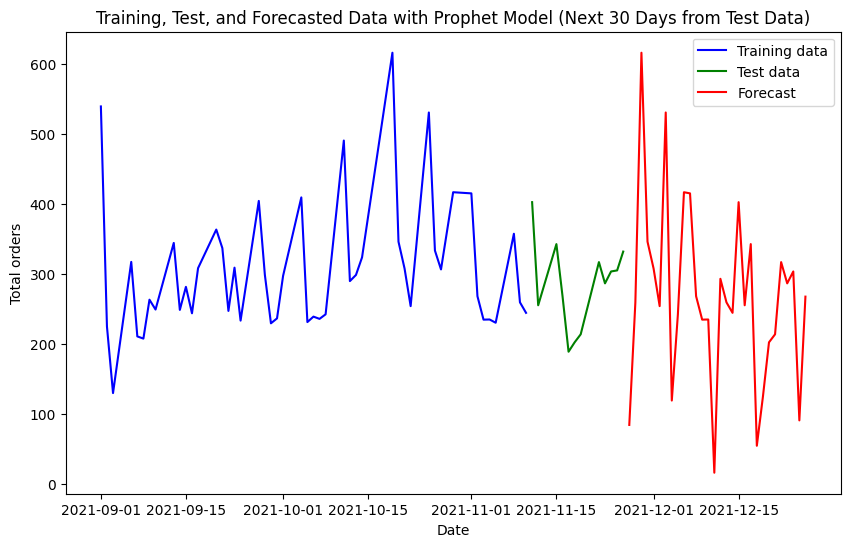

In [52]:

# Assuming df contains your dataset
data = df[['Target (Total orders)', 'Urgent order', 'Non-urgent order','Order type A', 'Order type B', 'Order type C', 'date_logistic']]
data.columns = ['y', 'X1', 'X2','X3','X4','X5' ,'ds']  # Renaming columns for Prophet

# Splitting data into train and test sets (80-20 split)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]
# print(data)
# Fitting Prophet model with additional regressors

model = Prophet(
    growth='linear',  # Choose 'linear' or 'logistic' based on your data's growth
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # Adjust as needed
    changepoint_prior_scale=0.03,  # Adjusting the flexibility of trend changes
    interval_width=0.95  # Confidence interval
)


# model = Prophet()
model.add_regressor('X1')
model.add_regressor('X2')
model.add_regressor('X3')
model.add_regressor('X4')
model.add_regressor('X5')

model.fit(train)

# Finding the last date in the test set
last_date = test['ds'].max()

# Creating a dataframe for future predictions starting from the last date in test data for the next 30 days
future = pd.DataFrame({'ds': pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')})
future['X1'] = data['X1'].tail(30).reset_index(drop=True)  # Exogenous variables for the forecast period
# print(future)
future['X2'] = data['X2'].tail(30).reset_index(drop=True)
future['X3'] = data['X3'].tail(30).reset_index(drop=True)
future['X4'] = data['X4'].tail(30).reset_index(drop=True)
future['X5'] = data['X5'].tail(30).reset_index(drop=True)
forecast = model.predict(future)

# Extracting forecast for the next 30 days
forecast_values = forecast['yhat']


# Calculate evaluation metrics
r2 = r2_score(test['y'], forecast_values[:len(test)])
rmse = mean_squared_error(test['y'], forecast_values[:len(test)], squared=False)
mae = mean_absolute_error(test['y'], forecast_values[:len(test)])
mape = 100 * (mae / test['y'].mean())

# Print evaluation metrics
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")




# Plotting training, test, and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Training data', color='blue')
plt.plot(test['ds'], test['y'], label='Test data', color='green')
plt.plot(future['ds'], forecast_values, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Total orders')
plt.title('Training, Test, and Forecasted Data with Prophet Model (Next 30 Days from Test Data)')
plt.legend()
plt.show()



DEBUG:cmdstanpy:input tempfile: /tmp/tmp4dqxu8ps/yfu1rw91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4dqxu8ps/1xct3bgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8949', 'data', 'file=/tmp/tmp4dqxu8ps/yfu1rw91.json', 'init=/tmp/tmp4dqxu8ps/1xct3bgo.json', 'output', 'file=/tmp/tmp4dqxu8ps/prophet_modelowhvvkx0/prophet_model-20231225131204.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:12:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R-squared (R2) Score: -5.0263
Root Mean Squared Error (RMSE): 147.8971
Mean Absolute Error (MAE): 121.6494
Mean Absolute Percentage Error (MAPE): 42.7264%


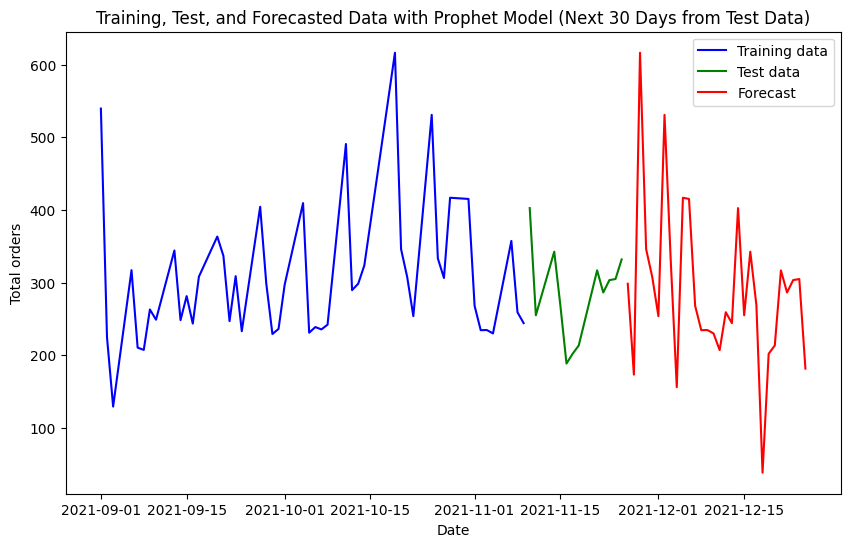

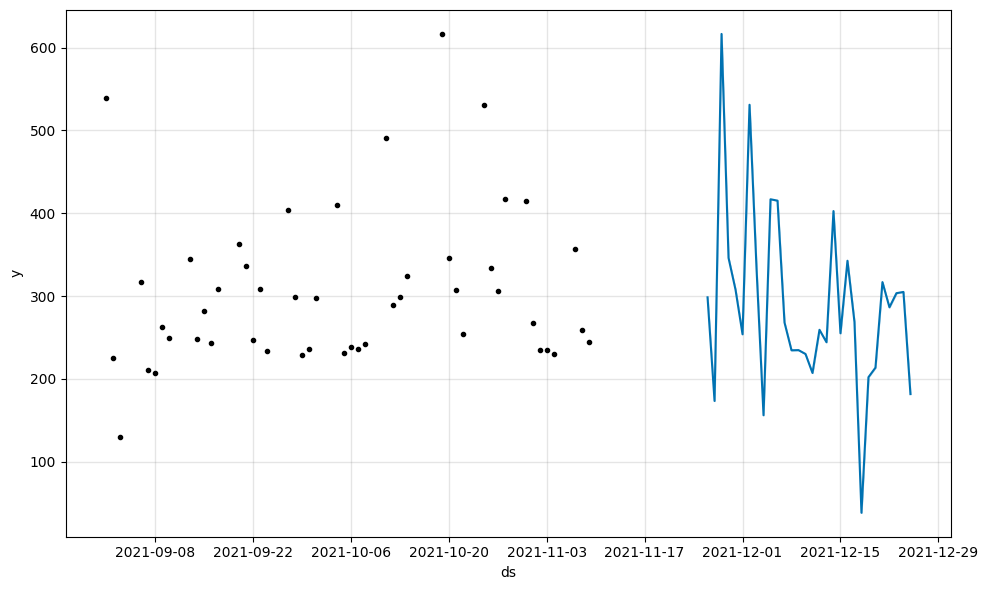

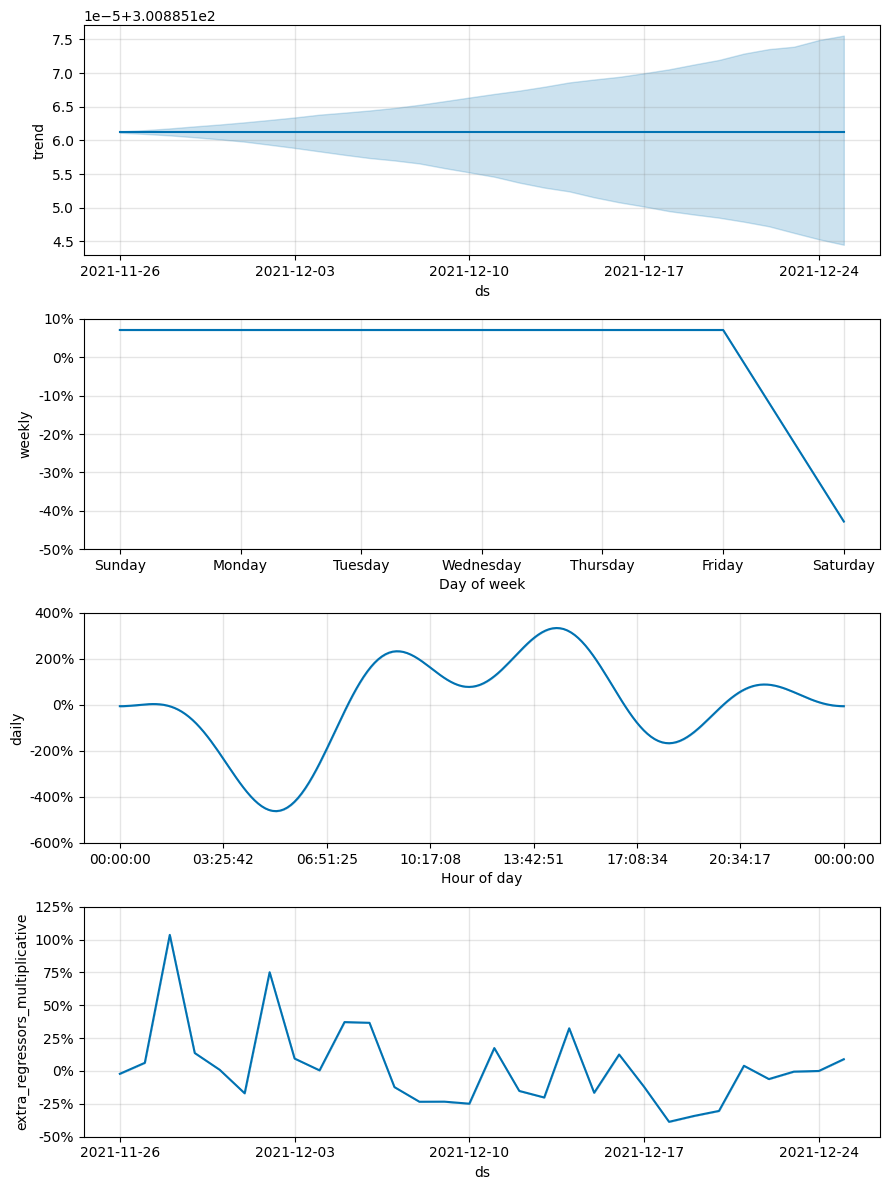

In [ ]:
# Assuming df contains your dataset
data = df[['Target (Total orders)', 'Urgent order', 'Non-urgent order', 'Order type A', 'Order type B', 'Order type C','Orders from the traffic controller sector',
           'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)', 'date_logistic']]
data.columns = ['y', 'X1', 'X2', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'ds']  # Renaming columns for Prophet

# # Handling missing values in exogenous variables
# for col in ['X1', 'X2', 'X3',  'X5', 'X6', 'X7', 'X8', 'X9', 'X10']:
#     data[col].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Splitting data into train and test sets (80-20 split)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Fitting Prophet model with additional regressors

model = Prophet(
    growth='linear',  # Choose 'linear' or 'logistic' based on your data's growth
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # Adjust as needed
    changepoint_prior_scale=.03,  # Adjusting the flexibility of trend changes
    interval_width=0.95  # Confidence interval
)


for col in ['X1', 'X2', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']:
    model.add_regressor(col)
model.fit(train)

# Finding the last date in the test set
last_date = test['ds'].max()

# Creating a dataframe for future predictions starting from the last date in test data for the next 30 days
future = pd.DataFrame({'ds': pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')})
for col in ['X1', 'X2', 'X3',  'X5', 'X6', 'X7', 'X8', 'X9', 'X10']:
    future[col] = data[col].iloc[30:].reset_index(drop=True)  # Exogenous variables for the forecast period
forecast = model.predict(future)

# Extracting forecast for the next 30 days
forecast_values = forecast['yhat']

# Calculate evaluation metrics
r2 = r2_score(test['y'], forecast_values[:len(test)])
rmse = mean_squared_error(test['y'], forecast_values[:len(test)], squared=False)
mae = mean_absolute_error(test['y'], forecast_values[:len(test)])
mape = 100 * (mae / test['y'].mean())

# Print evaluation metrics
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

# Plotting training, test, and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Training data', color='blue')
plt.plot(test['ds'], test['y'], label='Test data', color='green')
plt.plot(future['ds'], forecast_values, label='Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Total orders')
plt.title('Training, Test, and Forecasted Data with Prophet Model (Next 30 Days from Test Data)')
plt.legend()
plt.show()
# Plotting the forecast
fig = model.plot(forecast)

# Plot selected components (trend, weekly, daily)
fig = model.plot_components(forecast)


In [54]:
# Assuming 'Date' is the column containing dates in your DataFrame
# Assuming 'df' has the 'Date' column and 'train_data' is the target DataFrame
demand_df=df
# Log scaling the 'Target (Total orders)' column
df_log = np.log(demand_df['Target (Total orders)'])

# Splitting data into train and test sets (80-20 split)
train_percentage = 80
train_final_index = round(len(df_log) * (train_percentage / 100))
train_data, test_data = df_log[0:train_final_index], df_log[train_final_index:]

train_data = pd.concat([train_data, df['date_logistic'].iloc[:48]], axis=1)
test_data = pd.concat([test_data, df['date_logistic'].iloc[48:]], axis=1)

# Prepare the data for Prophet
train_data_prophet = pd.DataFrame({'ds': train_data['date_logistic'], 'y': np.exp(train_data['Target (Total orders)'])})
test_data_prophet = pd.DataFrame({'ds': test_data['date_logistic'], 'y': np.exp(test_data['Target (Total orders)'])})



In [57]:
# train_data_prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmptpuz7uwf/dz2u2mmv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptpuz7uwf/m03jk3g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91475', 'data', 'file=/tmp/tmptpuz7uwf/dz2u2mmv.json', 'init=/tmp/tmptpuz7uwf/m03jk3g4.json', 'output', 'file=/tmp/tmptpuz7uwf/prophet_modelpaymb2qi/prophet_model-20240102104859.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R2 score: -4.379224851562435
Root Mean Squared Error: 122.72702107386087


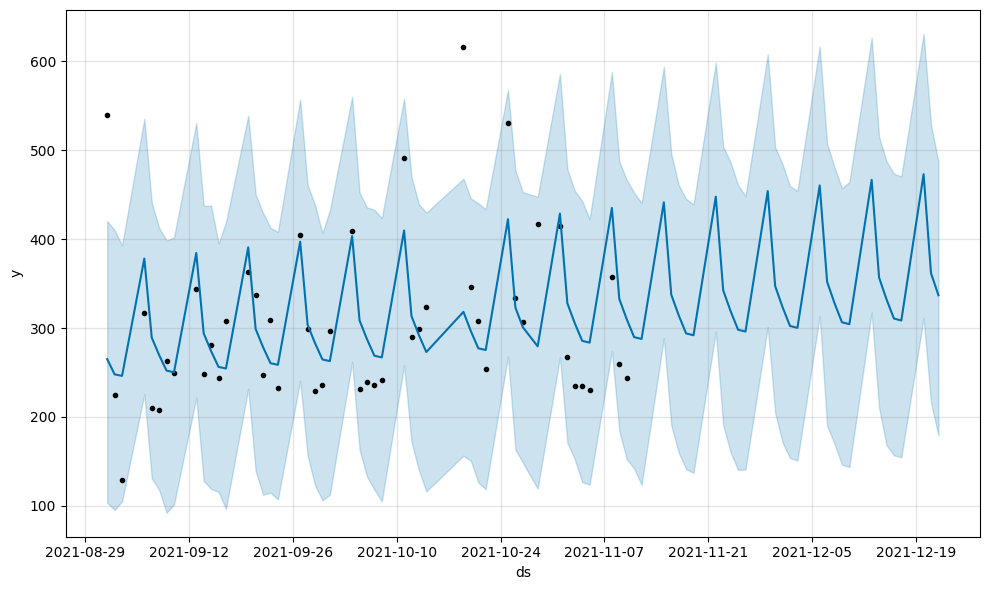

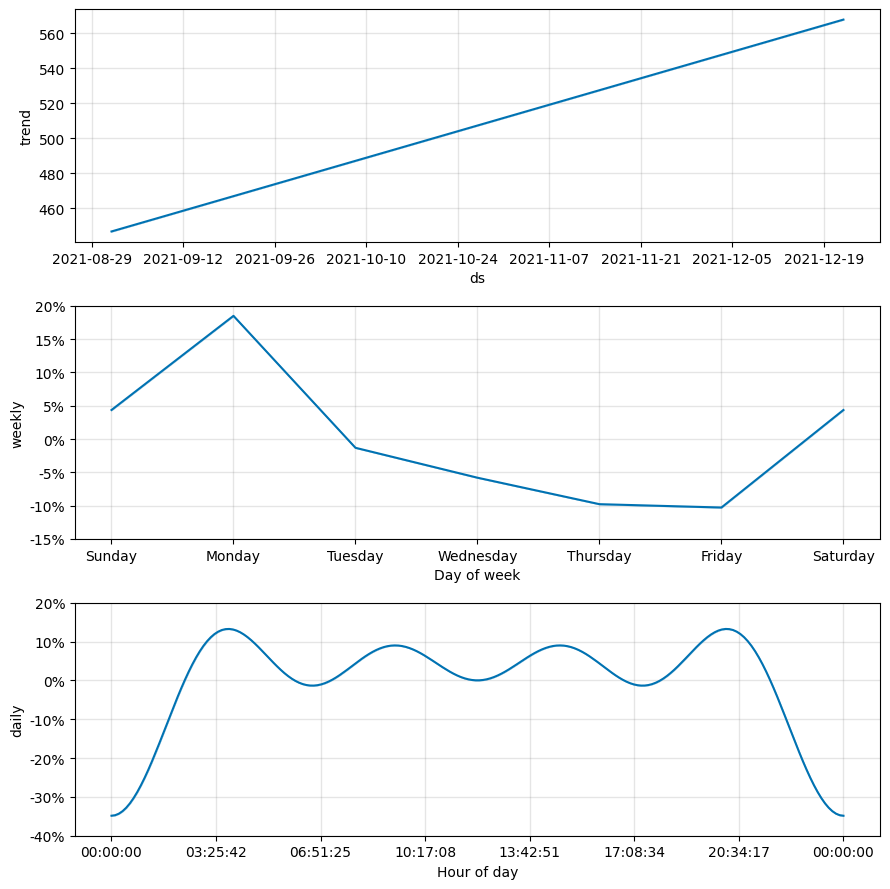

In [69]:
from prophet import Prophet

# Define and fit the model
model_prophet = Prophet(
    growth='linear',  # Choose 'linear' or 'logistic' based on your data's growth
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # Adjust as needed
    changepoint_prior_scale=0.01,  # Adjusting the flexibility of trend changes
    interval_width=0.95  # Confidence interval
)

# Fit the model
model_prophet.fit(train_data_prophet)


# Make predictions for the next 30 days
future = model_prophet.make_future_dataframe(periods=30, freq='B')  # Forecasting for the next 30 days
forecast_prophet = model_prophet.predict(future)
# print(forecast_prophet)


# Calculating R-squared (R2) score
y_true = np.exp(test_data['Target (Total orders)']).tail(10)
y_pred = (forecast_prophet['yhat'].tail(10))
print('R2 score:', r2_score(y_true, y_pred))
# print(test_data['Target (Total orders)'])
# print("*********************************************")
# print((forecast_prophet['yhat']))


# Calculating Root Mean Squared Error (RMSE)
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_true, y_pred)))


# Plotting the forecast
fig = model_prophet.plot(forecast_prophet)
# Plot selected components (trend, weekly, daily)
fig = model_prophet.plot_components(forecast_prophet)


In [70]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming you have a regressor named 'external_regressor' in your dataset
# You'll need to merge this regressor with your training data
external_regressor =['Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C']
train_data_with_regressor = train_data_prophet.merge(external_regressor, on='date_column')

# Define and fit the model with the regressor
model_prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.001,
    interval_width=0.95
)

# Add the regressor to the model
model_prophet.add_regressor('external_regressor')

# Fit the model with the regressor
model_prophet.fit(train_data_with_regressor)

# Make predictions for the next 30 days with the regressor
future = model_prophet.make_future_dataframe(periods=30, freq='B')
future_with_regressor = future.merge(external_regressor, on='date_column')  # Merge regressor with future data
forecast_prophet_with_regressor = model_prophet.predict(future_with_regressor)

# Calculate R-squared (R2) score
y_true = np.exp(test_data['Urgent order']).tail(10)
y_pred = np.exp(forecast_prophet_with_regressor['yhat'].tail(10))
print('R2 score:', r2_score(y_true, y_pred))

# Calculate Root Mean Squared Error (RMSE)
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_true, y_pred)))

# Plotting the forecast with the regressor
fig = model_prophet.plot(forecast_prophet_with_regressor)

# Plot selected components (trend, weekly, daily) with the regressor
fig = model_prophet.plot_components(forecast_prophet_with_regressor)


TypeError: ignored

# Prophet_Data_Preparation

In [18]:
df_final.columns

Index(['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)'],
      dtype='object')

In [11]:
# Create a DataFrame with 'date_logistic' and 'Target (Total orders)'
df_final = df[['date_logistic', 'Target (Total orders)']]

# Rename columns for Prophet
df_final.columns = ['ds', 'y']

# Add additional columns as regressors
regressor_columns = [
    'Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)'
]

# Include these columns in df_final
df_final = pd.concat([df_final, df[regressor_columns]], axis=1)


In [ ]:
from prophet import Prophet
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import numpy as np
import pickle

cont_col = ['Week of the month (first week, second, third, fourth or fifth week',
       'Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type A', 'Order type B', 'Order type C',
       'Fiscal sector orders', 'Orders from the traffic controller sector',
       'Banking orders (1)', 'Banking orders (2)', 'Banking orders (3)']

# Define the Prophet model with regressors
model = Prophet(
    # growth='linear',
#     seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    # changepoint_prior_scale=0.001,
    interval_width=0.95)


model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    )

# # Adding regressors to the model
model.add_regressor('Non-urgent order')
model.add_regressor('Urgent order')
model.add_regressor('Order type A')
model.add_regressor('Order type B')
model.add_regressor('Order type C')
model.add_regressor('Fiscal sector orders')
model.add_regressor('Orders from the traffic controller sector')
model.add_regressor('Banking orders (1)')
model.add_regressor('Banking orders (2)')
model.add_regressor('Banking orders (3)')



# print(df_final)
# Split data into features and target variable
X = df_final.drop(columns=['y'])  # Features
y = df_final['y']  # Target variable
# Splitting data into train-test (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(y_train)
# print("**********************************")
# print(y_test)

# Fit the Prophet model with the training data
model.fit(pd.concat([X_train, y_train], axis=1))

# Predict on the test data using the model
prediction = model.predict(pd.concat([X_test, y_test], axis=1))

# # Plotting the forecast
fig = model.plot(prediction)
# # Plot selected components (trend, weekly, daily)
fig = model.plot_components(prediction)


# Save the Prophet model
with open('fb_target_model.pkl', 'wb') as fout:
    pickle.dump(model, fout)

# Print error metrics
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, prediction['yhat'])))
print('R2 score:', r2_score(y_test, prediction['yhat']))


last_date = df_final['ds'].max()
# Create a future dataframe for the next 30 days
future = pd.DataFrame({'ds': pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')})

# Create future dataframe for forecast
# future = model.make_future_dataframe(periods=X_test.shape[0] + 10, freq='B', include_history=False)
# print(future)
# print("*********************************************")
future_values = future[:].reset_index(drop=True)
# print(future_values)
# print("****************************************************************")

# Train separate Prophet models for each column except 'ds' (continuous columns)
for col in cont_col:
    if col != 'ds':
        X_trial = X_train[[col, 'ds']]
        X_trial.rename(columns={col: 'y'}, inplace=True)

        col_model = Prophet(yearly_seasonality=False,
                            weekly_seasonality=True,
                            daily_seasonality=False,
                            interval_width=0.95)

        col_model.add_seasonality(name='weekly', period=30.5, fourier_order=5)
        col_model.fit(X_trial)

        model_names = 'fb_' + col + '_model.pkl'
        with open(model_names, 'wb') as fout:
            pickle.dump(col_model, fout)

        future_values[col] = col_model.predict(future_values)['yhat']




# Forecast future data using the main Prophet model
# print(future_values)
future_values['Forecasted_Order'] = model.predict(future_values)['yhat']
# print(future_values['Forecasted_Order'])




# Load Lasso Model and predict
lasso_model = joblib.load('lasso_reg.h5')
future_values['Predicted_Order'] = lasso_model.predict(future_values[cont_col])
# print(future_values)
# Error between Forecasted and Predicted values
print('RMSE:', np.sqrt(mean_squared_error(future_values['Forecasted_Order'], future_values['Predicted_Order'])))
print('R2 score:', r2_score(future_values['Forecasted_Order'], future_values['Predicted_Order']))


In [ ]:
future_values

In [ ]:
df_final

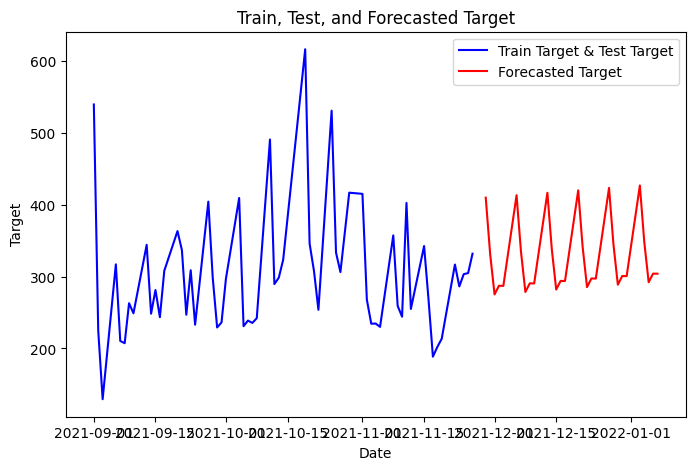

In [17]:
import matplotlib.pyplot as plt

# Convert 'ds' column in future_values to datetime
future_values['ds'] = pd.to_datetime(future_values['ds'])

# Plotting
plt.figure(figsize=(8, 5))

# Plotting Train and Test Targets
plt.plot(df_final['ds'], df_final['y'], label='Train Target & Test Target', color='blue')
# plt.plot(y_test.index, y_test, label='Test Target', color='green')

# Plotting Forecasted Targets
plt.plot(future_values['ds'], future_values['Predicted_Order'], label='Forecasted Target', color='red')


plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Train, Test, and Forecasted Target')
plt.legend()
plt.show()


In [35]:
plt.plot ()

pandas.core.frame.DataFrame

In [36]:
future_values.to_excel('prophet_data.xlsx', index=False)
